# <img src="https://filoger.com/wp-content/uploads/2021/09/circle-logo-1536x1536.png" alt="keras" width="150" height="150">
<h1 align=center><font size = 7>Lab 06 : Logistic Regression</font></h1>
<h1 align=center><font size = 4>Hands-On Machine Learning, 1401 | DeadLine: 10rd Aban, 13:00 </font></h1>



# Step0: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import math
from sklearn.pipeline import Pipeline

# Step1: Read Data

In [2]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')

# Step2: Data Overview

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


* tenure and products_number are ordinal variables. credit_card and active_member are binary categorical variables.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.describe(exclude='O')

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df.describe(include='O')

,country,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [7]:
df.shape[0], len(df.customer_id.unique())

(10000, 10000)

* So, each row corresponds to a customer.

In [8]:
df.churn.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

<AxesSubplot:xlabel='churn', ylabel='count'>

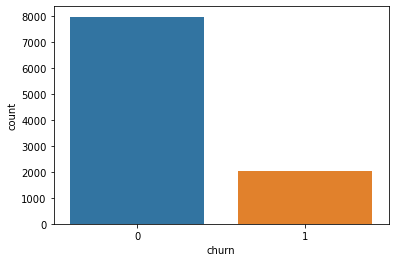

In [9]:
sns.countplot(data=df, x='churn')

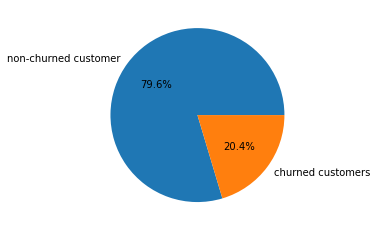

In [10]:
plt.pie(df['churn'].value_counts(), labels =['non-churned customers', 'churned customers'], autopct='%1.1f%%')
plt.show()

* The data set is imbalanced.

Only 20.4% of data are related to the churned customers and 79.6% of data are related to the non-churned customer. That’s a great difference. We have to oversample the minority class. For doing this, we can use SMOTE(Synthetic Minority Over-sampling TechniquE) which makes synthetic data using the characteristics of the nearest neighbours. This technique is available in the imblearn python library.


In [11]:
df.groupby('country')['churn'].value_counts()

country  churn
France   0        4204
         1         810
Germany  0        1695
         1         814
Spain    0        2064
         1         413
Name: churn, dtype: int64

<AxesSubplot:xlabel='country', ylabel='count'>

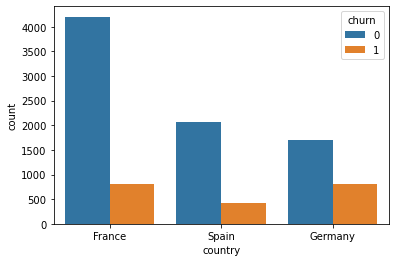

In [12]:
sns.countplot(data=df, x='country', hue='churn')

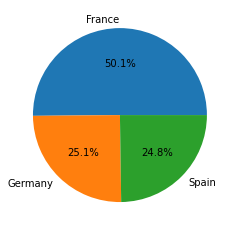

In [13]:
plt.pie(df.groupby('country')['churn'].count(), labels=df['country'].value_counts().index, autopct='%1.1f%%')
plt.show()

In [14]:
df.corr()['churn'].sort_values(ascending=False)

churn               1.000000
age                 0.285323
balance             0.118533
estimated_salary    0.012097
customer_id        -0.006248
credit_card        -0.007138
tenure             -0.014001
credit_score       -0.027094
products_number    -0.047820
active_member      -0.156128
Name: churn, dtype: float64

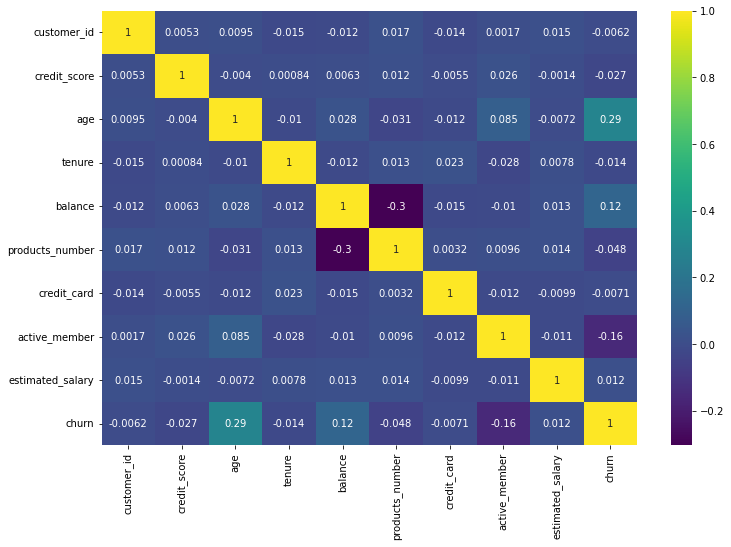

In [15]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()

<AxesSubplot:xlabel='gender', ylabel='count'>

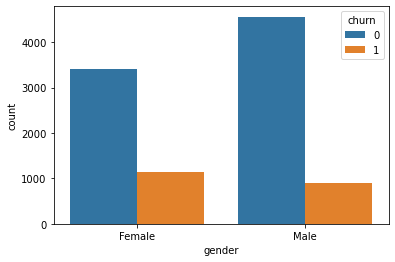

In [16]:
sns.countplot(data=df, x='gender', hue='churn')

In [17]:
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

# Step3: Data Preprocessing

* We will drop customer_id because it doesn't have any extra info. Each row pertains to a unique customer.
* Features can be segregated into non-essential, numerical, categorical, and target variables based on the above.

### One Hot Encoding for categorical Variables
* For gender and country.

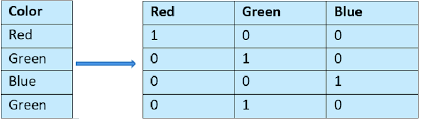

In [18]:
def one_hot_encoding(df):
    
    df_num = df.select_dtypes(exclude='object')
    df_obj = df.select_dtypes(include='object')
    
    # Converting:
    df_obj= pd.get_dummies(df_obj, drop_first=True)
    
    print('shape of df_obj:', df_obj.shape)
    display(df_obj)
    
    final_df= pd.concat([df_num, df_obj], axis=1)
    
    display(final_df.head())
    print(final_df.info())
    
    return final_df

In [19]:
df = one_hot_encoding(df)

shape of df_obj: (10000, 3)


,country_Germany,country_Spain,gender_Male
0,0,0,0
1,0,1,0
2,0,0,0
3,0,0,0
4,0,1,0
...,...,...,...
9995,0,0,1
9996,0,0,1
9997,0,0,0
9998,1,0,1


,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,15634602,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   age               10000 non-null  int64  
 3   tenure            10000 non-null  int64  
 4   balance           10000 non-null  float64
 5   products_number   10000 non-null  int64  
 6   credit_card       10000 non-null  int64  
 7   active_member     10000 non-null  int64  
 8   estimated_salary  10000 non-null  float64
 9   churn             10000 non-null  int64  
 10  country_Germany   10000 non-null  uint8  
 11  country_Spain     10000 non-null  uint8  
 12  gender_Male       10000 non-null  uint8  
dtypes: float64(2), int64(8), uint8(3)
memory usage: 810.7 KB
None


* Removing the non-essential columns.

In [20]:
df.drop('customer_id', axis=1, inplace=True)

# Step4: X, y

* Separating target variable.

In [21]:
X = df.drop(['churn'], axis=1)
y = df['churn']

In [22]:
X_corrected = df.drop(['churn'], axis=1)
y_corrected = df['churn']

<AxesSubplot:xlabel='credit_score', ylabel='Density'>

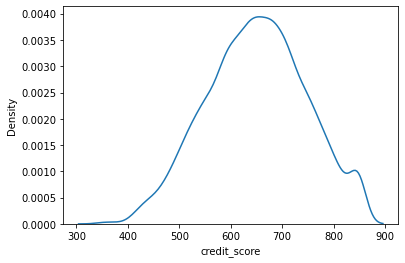

In [23]:
sns.kdeplot(X_corrected['credit_score'])

<AxesSubplot:xlabel='credit_score'>

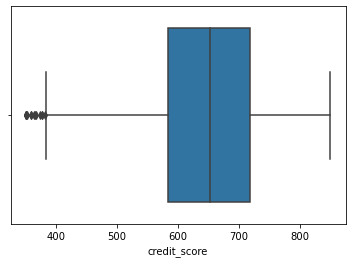

In [24]:
sns.boxplot(data=X_corrected, x='credit_score')

In [25]:
X_corrected['credit_score'] = X_corrected['credit_score'].apply(np.log)

<AxesSubplot:xlabel='credit_score'>

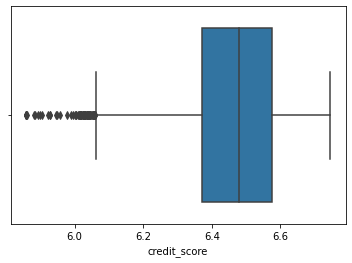

In [26]:
sns.boxplot(data=X_corrected, x='credit_score')

<AxesSubplot:xlabel='credit_score', ylabel='Density'>

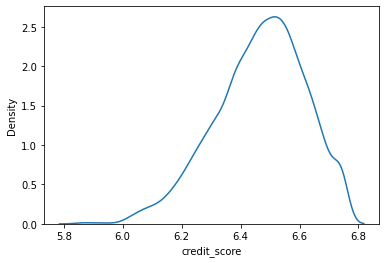

In [27]:
sns.kdeplot(X_corrected['credit_score'])

<AxesSubplot:xlabel='age'>

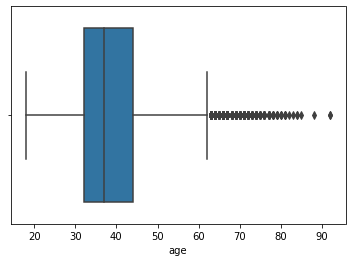

In [28]:
sns.boxplot(data=X_corrected, x='age')

<AxesSubplot:xlabel='age', ylabel='Density'>

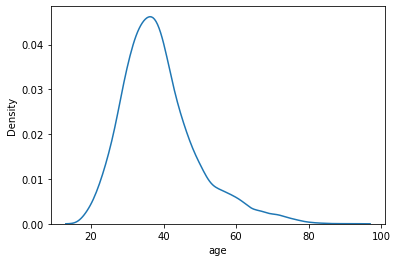

In [29]:
sns.kdeplot(X_corrected['age'])

In [30]:
X_corrected['age'] = X_corrected['age'].apply(np.log)

<AxesSubplot:xlabel='age', ylabel='Density'>

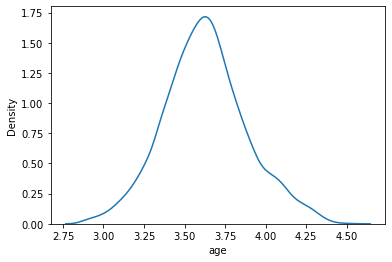

In [31]:
sns.kdeplot(X_corrected['age'])

<AxesSubplot:xlabel='balance'>

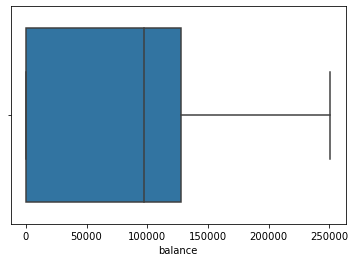

In [32]:
sns.boxplot(data=X_corrected, x='balance')

<AxesSubplot:xlabel='balance', ylabel='Density'>

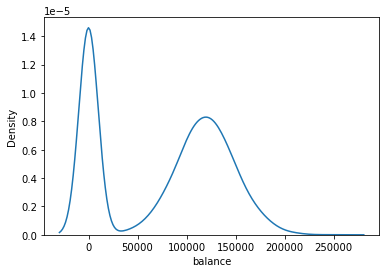

In [33]:
sns.kdeplot(X_corrected['balance'])

In [34]:
X_corrected['balance'] = X_corrected['balance'].apply(np.log)

<AxesSubplot:xlabel='balance', ylabel='Density'>

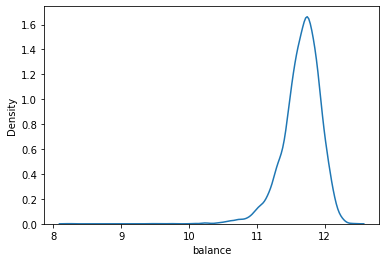

In [35]:
sns.kdeplot(X_corrected['balance'])

**SMOTE** (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances.

* Imbalanced data --> Accuracy is a bad machine learning metric.

Accuracy = (TP + TN) / (TP + TN + FP + FN)

* Step 1: Setting the minority class set A, for each $x \in A$, the k-nearest neighbors of x are obtained by calculating the Euclidean distance between x and every other sample in set A.
* Step 2: The sampling rate N is set according to the imbalanced proportion. For each $x \in A$, N examples (i.e x1, x2, …xn) are randomly selected from its k-nearest neighbors, and they construct the set $A_1$ .
* Step 3: For each example $x_k \in A_1$ (k=1, 2, 3…N), the following formula is used to generate a new example:
$x' = x + rand(0, 1) * \mid x - x_k \mid$
in which rand(0, 1) represents the random number between 0 and 1.

In [46]:
def over_sampling(X, y):
    
    resampler = SMOTE(random_state=101)

    # Resampling the data
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    # Resampled data
    
    return X_resampled, y_resampled

In [47]:
X_resampled, y_resampled = over_sampling(X, y)

In [45]:
# Resampled data
Counter(y), Counter(y_resampled)

(Counter({1: 2037, 0: 7963}), Counter({1: 7963, 0: 7963}))

In [48]:
X_corrected.replace([np.inf, -np.inf], 0, inplace=True)
X_corrected_resampled, y_corrected_resampled = over_sampling(X_corrected, y_corrected)

## train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train_corrected, X_test_corrected, y_train_corrected, y_test_corrected = train_test_split(X_corrected, y_corrected, 
                                                                                            test_size=0.2, random_state=42)

In [26]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, 
                                                                                            test_size=0.2, random_state=42)

In [27]:
X_train_corrected_resampled, X_test_corrected_resampled, y_train_corrected_resampled, y_test_corrected_resampled = train_test_split(X_corrected_resampled, 
                                                                        y_corrected_resampled, test_size=0.2, random_state=42)

In [28]:
def standard_scaler(X_train, X_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [29]:
X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)

In [30]:
X_train_corrected_scaled, X_test_corrected_scaled = standard_scaler(X_train_corrected, X_test_corrected)

In [31]:
X_train_resampled_scaled, X_test_resampled_scaled = standard_scaler(X_train_resampled, X_test_resampled)

In [32]:
X_train_corrected_resampled_scaled, X_test_corrected_resampled_scaled = standard_scaler(X_train_corrected_resampled, 
                                                                                        X_test_corrected_resampled)

In [33]:
X_Y_TEST = [(X_test_scaled, y_test), (X_test_corrected_scaled, y_test_corrected), (X_test_resampled_scaled, y_test_resampled), 
          (X_test_corrected_resampled_scaled, y_test_corrected_resampled)]

# Step5: Logistic Regression

## Creat the Model

## Train the Model

In [34]:
def train_model(X_train, y_train):
    
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    
    return logistic_model

In [35]:
logistic_model = train_model(X_train_scaled, y_train)

In [36]:
logistic_model_corrected = train_model(X_train_corrected_scaled, y_train_corrected)

In [37]:
logistic_model_resampled = train_model(X_train_resampled_scaled, y_train_resampled)

In [38]:
logistic_model_corrected_resampled = train_model(X_train_corrected_resampled_scaled, y_train_corrected_resampled)

In [39]:
models = [logistic_model, logistic_model_corrected, logistic_model_resampled, logistic_model_corrected_resampled]

## Print Coefficient

In [47]:
logistic_model.coef_

array([[-0.06768728,  0.75424167, -0.04268041,  0.1607895 , -0.06061145,
        -0.01026446, -0.53331601,  0.0157495 ,  0.33765759,  0.03932339,
        -0.26476246]])

In [48]:
logistic_model_resampled.coef_

array([[-0.10043213,  0.87470153, -0.14133686,  0.19026508, -0.34004819,
        -0.28245294, -0.86933757,  0.01348565,  0.07424821, -0.37932573,
        -0.63653757]])

##  Prediction & Evaluation
<hr>
print classification report

In [40]:
def prediction(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    display(pd.DataFrame({'Y_Test':y_test, 'Y_Pred':y_pred}))
    
    return y_pred

In [41]:
def evaluation_model(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1

Clearly, where class distribution is imbalanced, the accuracy metric is biased and not preferable.

* **Precision** means how well a model succeeds in identifying ONLY positive cases. 
* Precision = TruePositives / (TruePositives + FalsePositives)
* **Recall** means how well a model succeeds in identifying ALL the positive cases within the data.
* Recall = TruePositives / (TruePositives + FalseNegatives)
* F1 = 2 ∗ (Precision ∗ Recall) / (Precision + Recall)

In many cases, **false positives** are less problematic than **false negatives**.

An obvious example would be testing for the coronavirus. Imagine that sick people take a test and they obtain a false negative: they will go out and infect other people. On the other hand, if they are false positive they will be obliged to stay home: not ideal, but at least they do not form a public health hazard.

In [42]:
accuracy = []
precision = []
recall = []
f1 = []

for model, x_y_test in zip(models, X_Y_TEST):
    
    y_pred = prediction(model, x_y_test[0], x_y_test[1])
    acc, pre, rec, f = evaluation_model(x_y_test[1], y_pred)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    f1.append(f)

,Y_Test,Y_Pred
6252,0,0
4684,0,0
1731,0,0
4742,0,0
4521,0,0
...,...,...
6412,1,0
8285,0,0
7853,1,0
1095,1,0


,Y_Test,Y_Pred
6252,0,0
4684,0,0
1731,0,0
4742,0,0
4521,0,0
...,...,...
6412,1,0
8285,0,0
7853,1,0
1095,1,0


,Y_Test,Y_Pred
6126,0,0
7093,1,1
1659,0,0
15727,1,1
9682,0,1
...,...,...
11031,1,1
9747,1,1
5912,0,1
2879,1,1


,Y_Test,Y_Pred
6126,0,0
7093,1,1
1659,0,0
15727,1,1
9682,0,1
...,...,...
11031,1,1
9747,1,1
5912,0,1
2879,1,1


In [43]:
pd.DataFrame({'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1}).set_axis(['logistic_model', 
                       'logistic_model_corrected', 'logistic_model_resampled', 'logistic_model_corrected_resampled'], axis=0)

,accuracy,precision,recall,f1
logistic_model,0.811000,0.552448,0.201018,0.294776
logistic_model_corrected,0.814000,0.570470,0.216285,0.313653
logistic_model_resampled,0.785311,0.772414,0.793303,0.782719
logistic_model_corrected_resampled,0.784055,0.771160,0.792015,0.781449


In [76]:
y_pred = prediction(logistic_model_resampled, X_test_resampled_scaled, y_test_resampled)

,Y_Test,Y_Pred
6126,0,0
7093,1,1
1659,0,0
15727,1,1
9682,0,1
...,...,...
11031,1,1
9747,1,1
5912,0,1
2879,1,1


C:\Users\Marzie_Thr\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


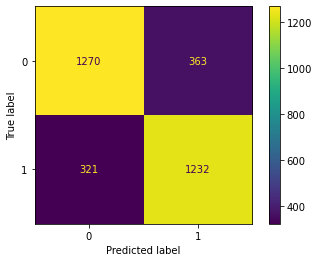

In [75]:
plot_confusion_matrix(logistic_model_resampled, X_test_resampled_scaled, y_test_resampled)

In [79]:
print(classification_report(y_test_resampled, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1633
           1       0.77      0.79      0.78      1553

    accuracy                           0.79      3186
   macro avg       0.79      0.79      0.79      3186
weighted avg       0.79      0.79      0.79      3186



## Important Features

In [57]:
feature_names = X.columns.to_list()

In [58]:
feature_names

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary',
 'country_Germany',
 'country_Spain',
 'gender_Male']

In [50]:
w = logistic_model_resampled.coef_[0]
w0 = logistic_model_resampled.intercept_[0]

In [59]:
feature_importance = pd.DataFrame(feature_names, columns=['Feature'])

In [62]:
feature_importance['importance'] = pow(math.e, w)

In [66]:
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)

In [67]:
feature_importance

,Feature,importance
1,age,2.398159
3,balance,1.209570
8,country_Germany,1.077074
7,estimated_salary,1.013577
0,credit_score,0.904446
2,tenure,0.868197
5,credit_card,0.753932
4,products_number,0.711736
9,country_Spain,0.684323
10,gender_Male,0.529121


In [80]:
steps = [('scaler', StandardScaler()),
         ('clf', LogisticRegression())]

pipe_lr = Pipeline(steps)

pipe_lr.fit(X_resampled, y_resampled)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', LogisticRegression())])

<div class="alert alert-success" role="alert">
  <h1 class="alert-heading">Well done!</h1>
  <p>Best Wishes!, Filoger</p>
</div>